<a href="https://colab.research.google.com/github/kalyanchakri02/ml-latest/blob/main/feature_training_catboost_gpu_repair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SWE Rules Baseline (No Training)
Accuracy          : 0.7234
Balanced Accuracy : 0.5343
F1 Macro          : 0.5359
F1 Weighted       : 0.7276

              precision    recall  f1-score   support

   No Action       0.86      0.82      0.84      6033
      Reboot       0.54      0.54      0.54      1714
      Reseat       0.42      0.54      0.47      1069
         RMA       0.39      0.24      0.30       184

    accuracy                           0.72      9000
   macro avg       0.55      0.53      0.54      9000
weighted avg       0.73      0.72      0.73      9000



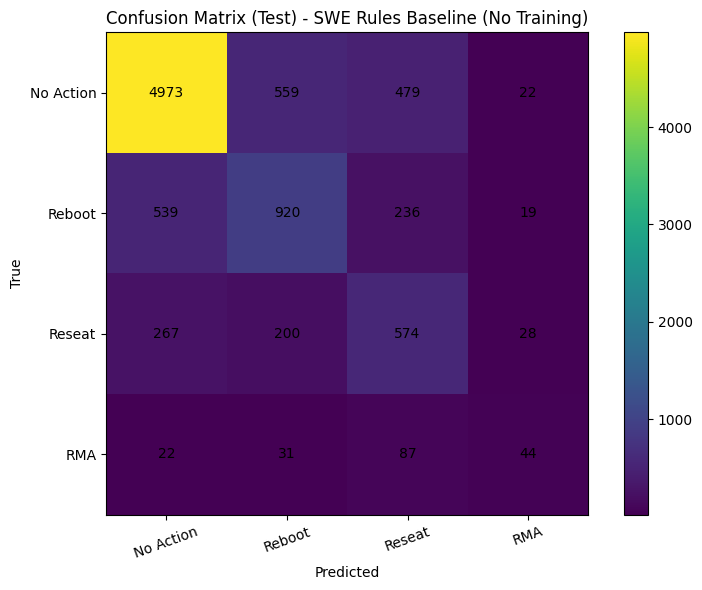

0:	learn: 0.6373828	test: 0.6382976	best: 0.6382976 (0)	total: 321ms	remaining: 2m 39s
100:	learn: 0.6757537	test: 0.6616397	best: 0.6619500 (86)	total: 28.7s	remaining: 1m 53s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.6620604696
bestIteration = 107

Shrink model to first 108 iterations.
ML (CatBoost) - Raw + Engineered Features
Accuracy          : 0.7829
Balanced Accuracy : 0.6695
F1 Macro          : 0.6444
F1 Weighted       : 0.7859

              precision    recall  f1-score   support

   No Action       0.90      0.88      0.89      6033
      Reboot       0.55      0.60      0.57      1714
      Reseat       0.65      0.59      0.62      1069
         RMA       0.43      0.62      0.50       184

    accuracy                           0.78      9000
   macro avg       0.63      0.67      0.64      9000
weighted avg       0.79      0.78      0.79      9000



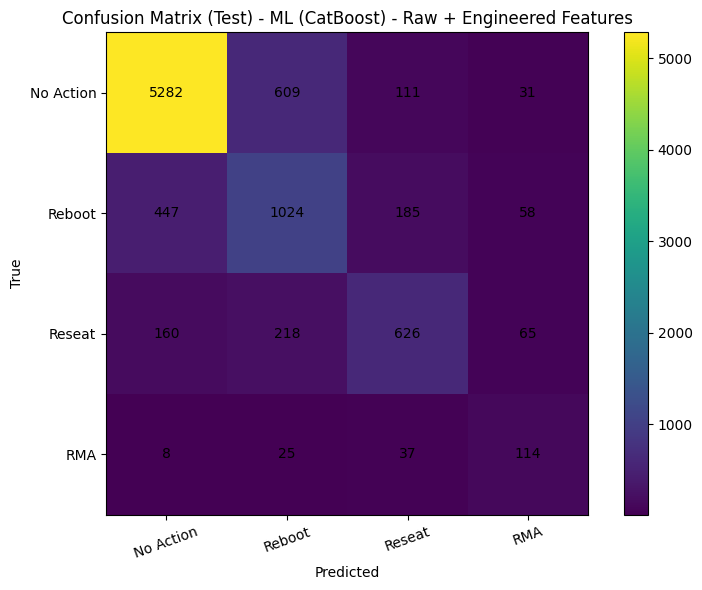

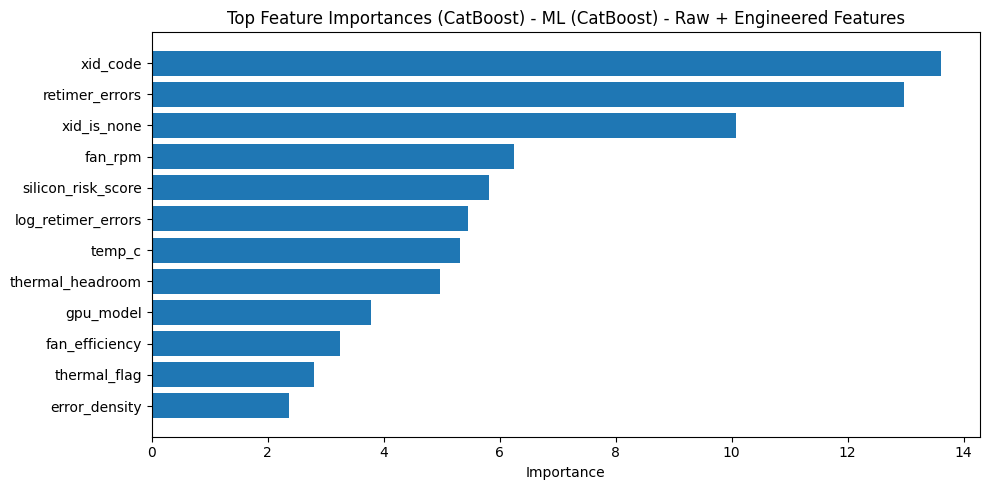

,title,accuracy,balanced_accuracy,f1_macro,f1_weighted
0,SWE Rules Baseline (No Training),0.723444,0.534284,0.535917,0.727557
1,ML (CatBoost) - Raw Telemetry Features,0.782889,0.669745,0.641458,0.785769
2,ML (CatBoost) - Raw + Engineered Features,0.782889,0.669528,0.644439,0.785864


In [6]:
!pip install catboost

# !pip install -q catboost

import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt

# =============================================================================
# Reproducibility & dataset sizing
# =============================================================================
np.random.seed(42)
n_samples = 60000

target_names = ["No Action", "Reboot", "Reseat", "RMA"]  # 0..3

# =============================================================================
# STEP 1: Latent fault domains (hidden)
# =============================================================================
fault_domains = np.random.choice(
    ["healthy", "software", "signal", "thermal", "silicon"],
    size=n_samples,
    p=[0.70, 0.12, 0.10, 0.06, 0.02]
)

gpu_model = np.random.choice(
    ["H100", "A100", "V100", "H200", "GB200"],
    n_samples,
    p=[0.30, 0.25, 0.20, 0.15, 0.10]
)

is_active_cooling = np.random.choice([0, 1], n_samples, p=[0.92, 0.08])

def normal_by_domain(dom, means, stds):
    mu = np.vectorize(means.get)(dom)
    sd = np.vectorize(stds.get)(dom)
    return np.random.normal(mu, sd, size=len(dom))

# =============================================================================
# STEP 2: Observable telemetry/log signals (correlated but noisy)
# =============================================================================
temp_c = normal_by_domain(
    fault_domains,
    means={"healthy": 70, "software": 72, "signal": 73, "thermal": 95, "silicon": 85},
    stds={"healthy": 10, "software": 12, "signal": 12, "thermal": 6, "silicon": 10},
)
temp_c = np.clip(temp_c, 20, 110)

fan_rpm = normal_by_domain(
    fault_domains,
    means={"healthy": 2500, "software": 2600, "signal": 2550, "thermal": 4200, "silicon": 2600},
    stds={"healthy": 700, "software": 800, "signal": 800, "thermal": 600, "silicon": 800},
)
fan_rpm = np.clip(fan_rpm, 0, 6000)

voltage = normal_by_domain(
    fault_domains,
    means={"healthy": 1.20, "software": 1.20, "signal": 1.19, "thermal": 1.18, "silicon": 1.15},
    stds={"healthy": 0.06, "software": 0.06, "signal": 0.07, "thermal": 0.08, "silicon": 0.10},
)
voltage = np.clip(voltage, 0.8, 1.4)

retimer_errors = np.random.poisson(
    lam=np.where(
        fault_domains == "signal", 6.0,
        np.where(
            fault_domains == "thermal", 0.6,
            np.where(
                fault_domains == "software", 0.4,
                np.where(fault_domains == "silicon", 1.0, 0.2)
            )
        )
    ),
    size=n_samples
)

pcie_width = np.where(
    fault_domains == "signal",
    np.random.choice([16, 8, 4, 1], n_samples, p=[0.50, 0.30, 0.15, 0.05]),
    np.where(
        fault_domains == "silicon",
        np.random.choice([16, 8, 4, 1], n_samples, p=[0.40, 0.25, 0.20, 0.15]),
        np.random.choice([16, 8, 4, 1], n_samples, p=[0.94, 0.03, 0.02, 0.01])
    )
).astype(int)

pcie_gen = np.where(
    fault_domains == "signal",
    np.random.choice([5, 4, 3, 2, 1], n_samples, p=[0.60, 0.20, 0.15, 0.03, 0.02]),
    np.where(
        fault_domains == "silicon",
        np.random.choice([5, 4, 3, 2, 1], n_samples, p=[0.55, 0.15, 0.15, 0.10, 0.05]),
        np.random.choice([5, 4, 3, 2, 1], n_samples, p=[0.88, 0.06, 0.03, 0.02, 0.01])
    )
).astype(int)

xid_code = np.where(
    fault_domains == "software",
    np.random.choice(["XID_31", "XID_43", "XID_61", "NONE"], n_samples, p=[0.35, 0.30, 0.25, 0.10]),
    np.where(
        fault_domains == "signal",
        np.random.choice(["XID_79", "NONE", "XID_43"], n_samples, p=[0.45, 0.45, 0.10]),
        np.where(
            fault_domains == "silicon",
            np.random.choice(["XID_79", "NONE", "XID_61"], n_samples, p=[0.55, 0.25, 0.20]),
            np.random.choice(["NONE", "XID_31", "XID_43", "XID_61", "XID_79"], n_samples,
                             p=[0.92, 0.03, 0.02, 0.02, 0.01])
        )
    )
)

error_count_24h = np.random.poisson(
    lam=np.where(
        fault_domains == "silicon", 4.5,
        np.where(
            fault_domains == "thermal", 1.2,
            np.where(
                fault_domains == "signal", 1.0,
                np.where(fault_domains == "software", 0.8, 0.3)
            )
        )
    ),
    size=n_samples
)

unfixable_ecc_errors = np.random.binomial(
    n=1,
    p=np.where(fault_domains == "silicon", 0.25, 0.003),
    size=n_samples
).astype(int)

node_age_days = np.random.exponential(scale=180, size=n_samples).astype(int)

prior_recovery_failures = np.random.poisson(
    lam=np.where(
        fault_domains == "healthy", 0.05,
        np.where(
            fault_domains == "software", 0.2,
            np.where(
                fault_domains == "signal", 0.4,
                np.where(fault_domains == "thermal", 0.5, 1.2)
            )
        )
    ),
    size=n_samples
)

df_raw = pd.DataFrame({
    "temp_c": temp_c,
    "fan_rpm": fan_rpm.astype(int),
    "voltage": voltage,
    "error_count_24h": error_count_24h,
    "pcie_width": pcie_width,
    "pcie_gen": pcie_gen,
    "retimer_errors": retimer_errors,
    "gpu_model": gpu_model,
    "xid_code": xid_code,
    "is_active_cooling": is_active_cooling.astype(int),
    "unfixable_ecc_errors": unfixable_ecc_errors,
    "node_age_days": node_age_days,
    "prior_recovery_failures": prior_recovery_failures
})

# =============================================================================
# STEP 3A: Define "Ground Truth" actions from latent domains (NOT from rules)
# -----------------------------------------------------------------------------
# This is the "should do" label, representing ideal orchestration outcome.
# We add probabilistic overlap to reflect ambiguity in practice.
# =============================================================================
domain_to_action_probs = {
    "healthy":  [0.92, 0.06, 0.02, 0.00],
    "software": [0.10, 0.78, 0.11, 0.01],
    "signal":   [0.06, 0.18, 0.72, 0.04],
    "thermal":  [0.08, 0.65, 0.25, 0.02],
    "silicon":  [0.01, 0.08, 0.26, 0.65],
}

def sample_ground_truth_action(domains: np.ndarray) -> np.ndarray:
    y = np.zeros(len(domains), dtype=int)
    for i, d in enumerate(domains):
        y[i] = np.random.choice([0,1,2,3], p=domain_to_action_probs[d])
    return y

y_true = sample_ground_truth_action(fault_domains)

# Optional: inject additional "operator + telemetry ambiguity" label noise
noise_rate = 0.03
flip = np.random.rand(len(y_true)) < noise_rate
y_true[flip] = np.random.choice([0,1,2,3], size=flip.sum(), p=[0.70, 0.15, 0.12, 0.03])

df_raw["action_true"] = y_true

# =============================================================================
# STEP 3B: SWE baseline rules (heuristic predictor)
# -----------------------------------------------------------------------------
# This is your "rule engine" baseline to compare ML against.
# IMPORTANT: these are intentionally imperfect relative to y_true.
# =============================================================================
def rules_predict_action(row) -> int:
    # Tier 3: RMA
    if row["unfixable_ecc_errors"] > 0 or row["error_count_24h"] > 6:
        return 3
    if row["xid_code"] == "XID_79" and row["pcie_width"] <= 1:
        return 3

    # Tier 2: Physical / signal intervention
    if row["pcie_width"] < 16:
        return 2
    if row["retimer_errors"] > 6:
        return 2
    if row["xid_code"] == "XID_79" and row["pcie_width"] > 1:
        return 2

    # Tier 1: Recoverable / reboot
    if row["temp_c"] > 92 and row["fan_rpm"] >= 500:
        return 1
    if row["xid_code"] in ["XID_43", "XID_31", "XID_61"]:
        return 1

    return 0

df_raw["action_rules"] = df_raw.apply(rules_predict_action, axis=1)

# =============================================================================
# STEP 4: Feature extraction (engineered features)
# =============================================================================
def add_extracted_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    eps = 1e-6

    d["log_retimer_errors"] = np.log1p(d["retimer_errors"])
    d["log_error_count_24h"] = np.log1p(d["error_count_24h"])
    d["log_prior_recovery_failures"] = np.log1p(d["prior_recovery_failures"])
    d["log_node_age_days"] = np.log1p(d["node_age_days"])

    d["thermal_headroom"] = 110 - d["temp_c"]
    d["thermal_flag"] = (d["temp_c"] > 90).astype(int)
    d["fan_efficiency"] = d["fan_rpm"] / (d["temp_c"] + eps)
    d["cooling_mismatch"] = (
        (d["is_active_cooling"] == 1) & (d["temp_c"] > 90) & (d["fan_rpm"] < 1200)
    ).astype(int)

    d["voltage_droop"] = 1.20 - d["voltage"]
    d["droop_severity"] = np.maximum(0.0, 1.18 - d["voltage"])
    d["thermal_power_coupling"] = d["temp_c"] * d["voltage_droop"]

    d["pcie_bw_score"] = d["pcie_width"] * d["pcie_gen"]
    d["pcie_degraded"] = ((d["pcie_width"] < 16) | (d["pcie_gen"] < 5)).astype(int)
    d["signal_integrity_score"] = d["log_retimer_errors"] + 2.0 * d["pcie_degraded"]

    d["error_density"] = d["error_count_24h"] / (d["node_age_days"] + 1.0)
    d["ecc_present"] = d["unfixable_ecc_errors"].astype(int)
    d["silicon_risk_score"] = (
        3.0 * d["ecc_present"]
        + d["log_error_count_24h"]
        + 0.7 * np.maximum(0.0, d["voltage_droop"])
        + 0.3 * d["log_prior_recovery_failures"]
    )

    d["xid_is_none"] = (d["xid_code"] == "NONE").astype(int)
    d["xid_is_bus"] = (d["xid_code"] == "XID_79").astype(int)
    d["xid_is_hang"] = d["xid_code"].isin(["XID_31", "XID_43"]).astype(int)
    d["xid_is_reset"] = (d["xid_code"] == "XID_61").astype(int)

    d["repeat_failure_flag"] = (d["prior_recovery_failures"] >= 2).astype(int)
    d["recovery_pressure"] = d["prior_recovery_failures"] / (d["node_age_days"] + 7.0)

    return d

df_full = add_extracted_features(df_raw)

# =============================================================================
# STEP 5: Train/Val/Test split (stratified on ground truth)
# =============================================================================
y = df_raw["action_true"]

train_idx, temp_idx = train_test_split(
    df_raw.index, test_size=0.30, random_state=42, stratify=y
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50, random_state=42, stratify=y.loc[temp_idx]
)

# =============================================================================
# STEP 6: Evaluation helpers (rules baseline + ML)
# =============================================================================
def eval_predictions(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    print("=" * 90)
    print(title)
    print(f"Accuracy          : {acc:.4f}")
    print(f"Balanced Accuracy : {bal_acc:.4f}")
    print(f"F1 Macro          : {f1_macro:.4f}")
    print(f"F1 Weighted       : {f1_weighted:.4f}\n")
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm)
    plt.xticks(range(4), target_names, rotation=20)
    plt.yticks(range(4), target_names)
    plt.title(f"Confusion Matrix (Test) - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    for i in range(4):
        for j in range(4):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

    return {
        "title": title,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted
    }

def train_catboost_and_eval(X_df: pd.DataFrame, y_series: pd.Series, title: str):
    X_train, X_val, X_test = X_df.loc[train_idx], X_df.loc[val_idx], X_df.loc[test_idx]
    y_train, y_val, y_test = y_series.loc[train_idx], y_series.loc[val_idx], y_series.loc[test_idx]

    cat_cols = [c for c in ["gpu_model", "xid_code"] if c in X_df.columns]
    cat_features = [X_df.columns.get_loc(c) for c in cat_cols]

    counts = y_train.value_counts().sort_index()
    class_weights = (counts.sum() / (len(counts) * counts)).tolist()

    model = CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="TotalF1:average=Macro",
        iterations=500,
        learning_rate=0.07,
        depth=7,
        l2_leaf_reg=6,
        random_seed=42,
        class_weights=class_weights,
        od_type="Iter",
        od_wait=60,
        verbose=100
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    pred = model.predict(X_test).astype(int).reshape(-1)

    # metrics + confusion
    res = eval_predictions(y_test.values, pred, title)

    # feature importance
    imp = (
        pd.Series(model.get_feature_importance(), index=X_df.columns)
        .sort_values(ascending=False)
        .head(12)
    )
    plt.figure(figsize=(10, 5))
    plt.barh(imp.index[::-1], imp.values[::-1])
    plt.title(f"Top Feature Importances (CatBoost) - {title}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    return res

# =============================================================================
# STEP 7: Run comparative experiments
# =============================================================================
# 7A) SWE rules baseline on TEST set
y_test_true = df_raw.loc[test_idx, "action_true"].values
y_test_rules = df_raw.loc[test_idx, "action_rules"].values
res_rules = eval_predictions(y_test_true, y_test_rules, "SWE Rules Baseline (No Training)")


# 7C) ML with raw + engineered features
X_full = df_full.drop(columns=["action_true", "action_rules"])
res_ml_full = train_catboost_and_eval(X_full, y, "ML (CatBoost) - Raw + Engineered Features")

# =============================================================================
# STEP 8: Summary table
# =============================================================================
summary = pd.DataFrame([res_rules, res_ml_raw, res_ml_full])
summary
